In [6]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [7]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=mips_sweep"
checkpoint_name = "metrics.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

2312


In [8]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data['context'] = int(data['context'])
    data['lr'] = float(data['lr'])
    experiments.append(data)

In [12]:
for experiment in experiments:
    try:
        with open(experiment['file']) as f:
            results = json.load(f)

        epochs = [ep["EM"] for ep in results['validation']]
        best_number = np.argmax(epochs)

        experiment["EM"] = results['validation'][best_number]["EM"]
    except:
        continue

In [16]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("query_") or col.startswith("breakdown_"),results.columns)}
breakdown = pd.pivot_table(results, index=["model","retrieval","lr","scale","layers","grad"],columns=["version"],aggfunc=cols)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [23]:
print(pd.pivot_table(results, index=["model","retrieval","layers"],columns=["version"],aggfunc={"EM":np.max}))
print(pd.pivot_table(results, index=["model","retrieval","grad"],columns=["version"],aggfunc={"EM":np.max}))
print(pd.pivot_table(results, index=["model","retrieval","scale"],columns=["version"],aggfunc={"EM":np.max}))
print(pd.pivot_table(results, index=["model","retrieval","lr"],columns=["version"],aggfunc={"EM":np.max}))




                                EM
version                       v0.2
model   retrieval layers          
t5-base mips_bert 1       0.613296
                  12      0.614393
                  2       0.629956
                  4       0.628258
                  6       0.593778
                  8       0.600447
        mips_t5   1       0.608312
                  12      0.594370
                  2       0.603590
                  4       0.602218
                  6       0.600210
                  8       0.592758
                              EM
version                     v0.2
model   retrieval grad          
t5-base mips_bert 16    0.598928
                  32    0.551766
                  4     0.629956
                  64    0.490873
                  8     0.606587
        mips_t5   16    0.595536
                  32    0.574741
                  4     0.603590
                  64    0.487977
                  8     0.608312
                               EM
version     

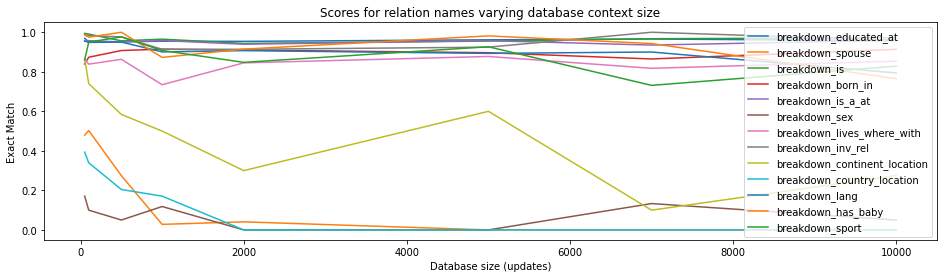

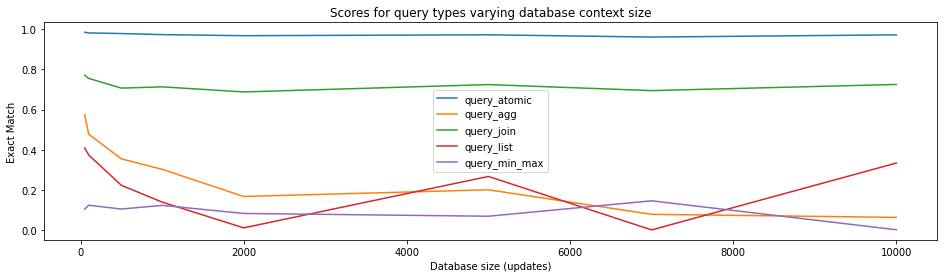

In [88]:
data_sizes = [50,100,500,1000,2000,5000,7000,1000]
plt.figure(figsize=(16,4))

a=[]
for col in breakdown_cols:
    means = breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4']
    std = breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4']
    a.append(means)

    plt.plot(means)



plt.title("Scores for relation names varying database context size")
plt.xlabel("Database size (updates)")
plt.ylabel("Exact Match")
plt.legend(breakdown_cols)

plt.show()


plt.figure(figsize=(16,4))

a=[]
for col in query_cols:
    means = breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4']
    std = breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4']
    a.append(means)

    plt.plot(means)



plt.title("Scores for query types varying database context size")
plt.xlabel("Database size (updates)")
plt.ylabel("Exact Match")
plt.legend(query_cols)


plt.show()


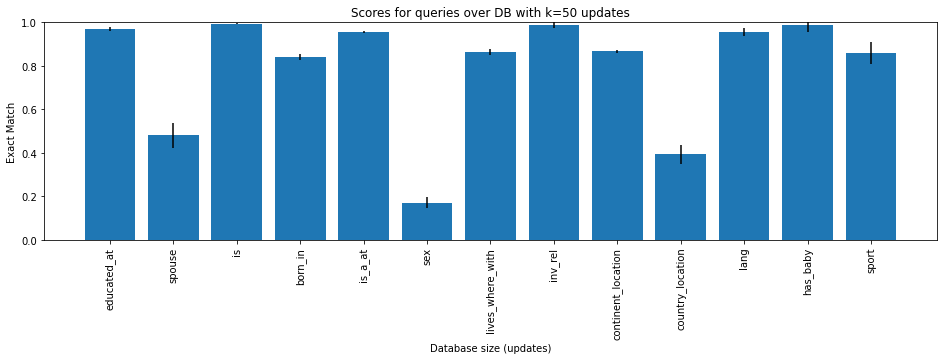

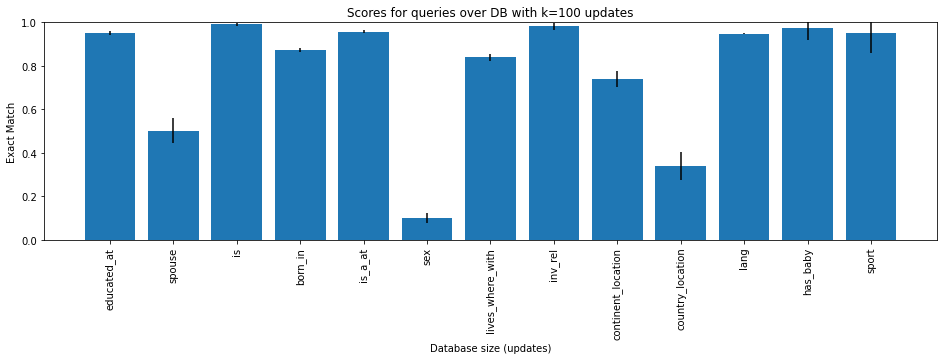

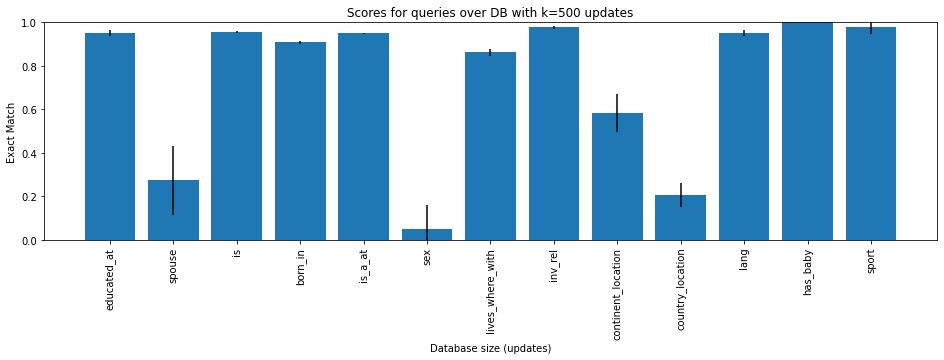

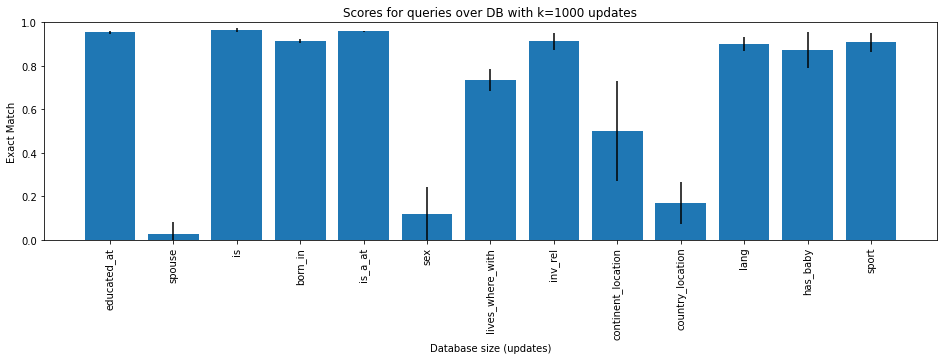

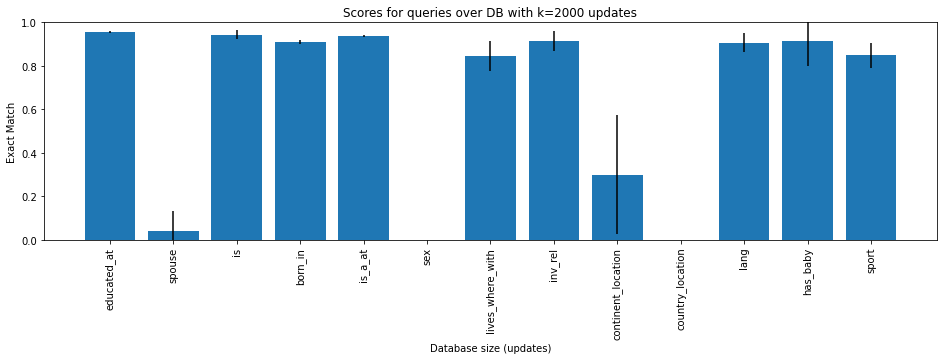

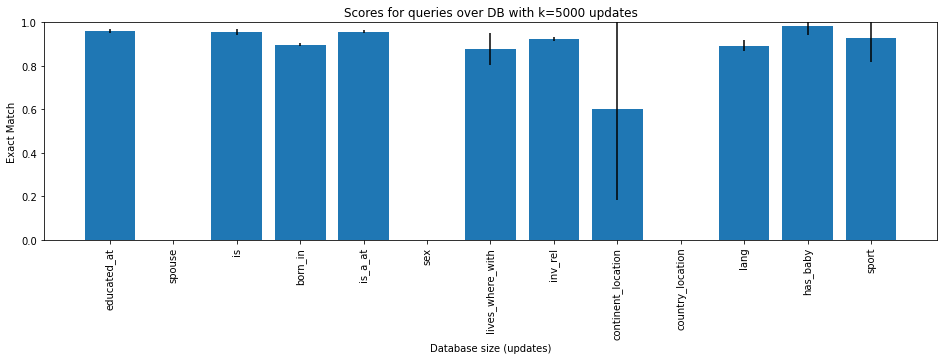

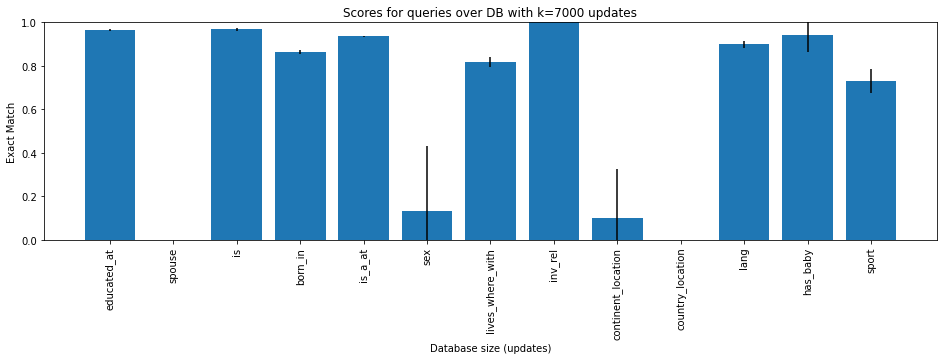

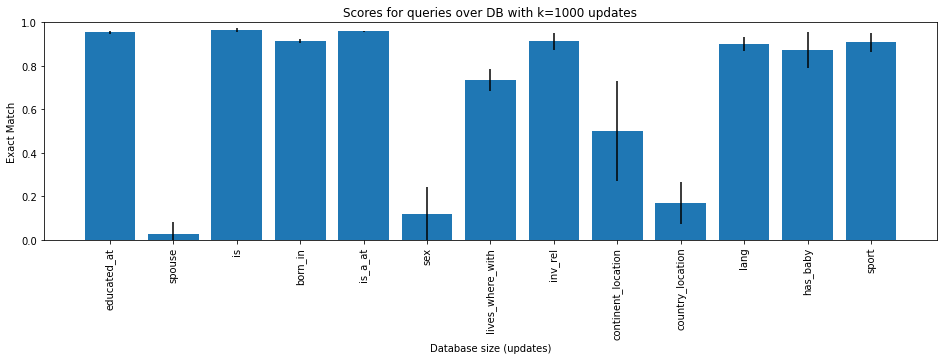

In [84]:
data_sizes = [50,100,500,1000,2000,5000,7000,1000]


a=[]
for size in data_sizes:
    plt.figure(figsize=(16,4))
    plt.title("Scores for queries over DB with k={} updates".format(size))
    plt.xlabel("Database size (updates)")
    plt.ylabel("Exact Match")
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    means = [breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in breakdown_cols]
    std = [breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in breakdown_cols]

    plt.bar([col.replace("breakdown_","") for col in breakdown_cols],means,yerr=std)



    plt.show()



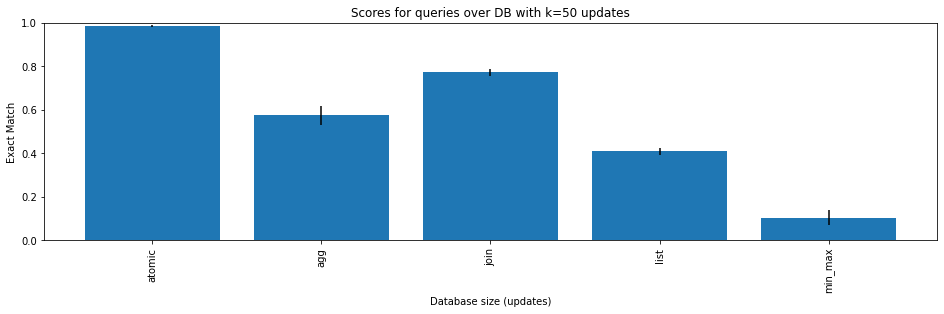

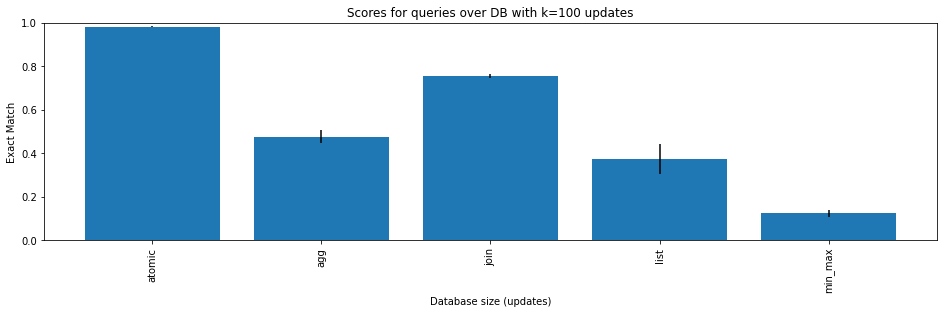

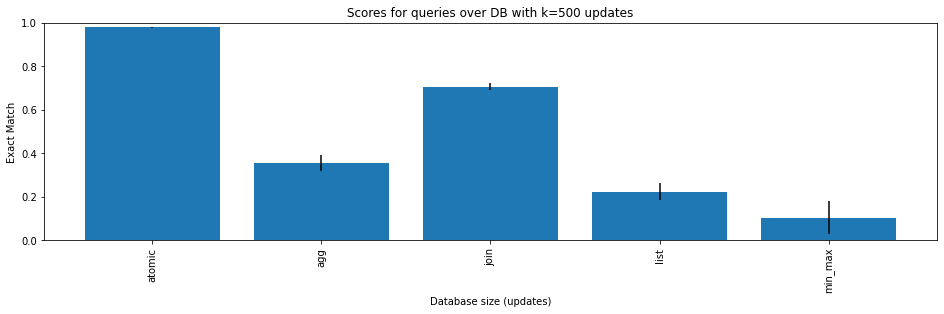

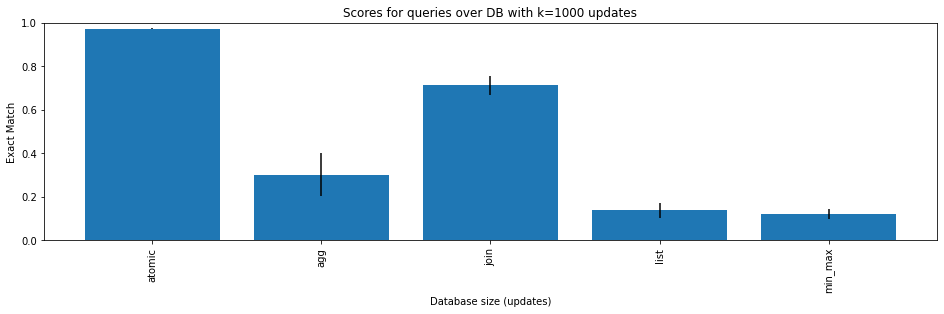

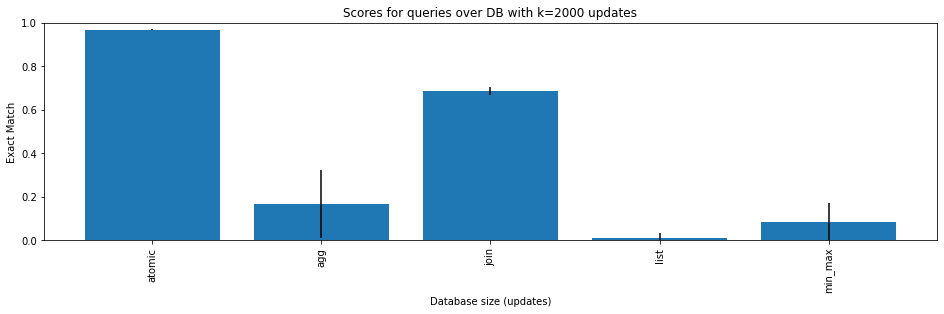

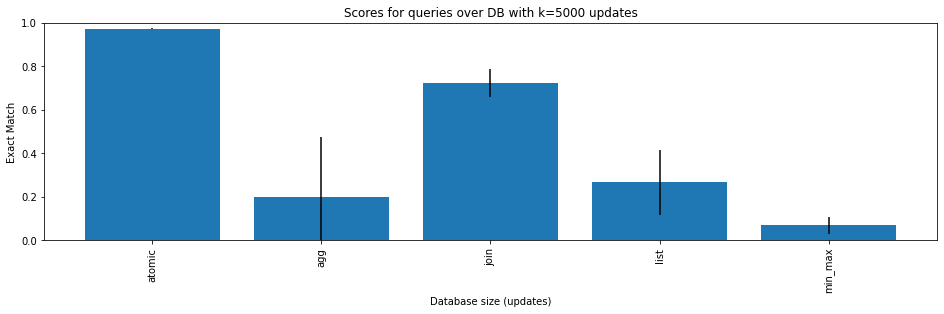

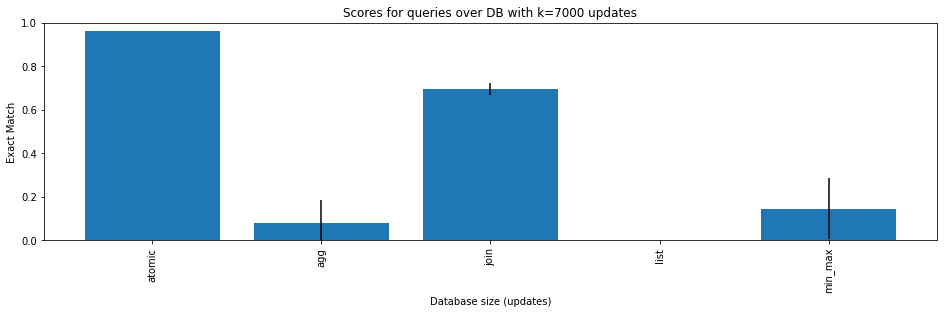

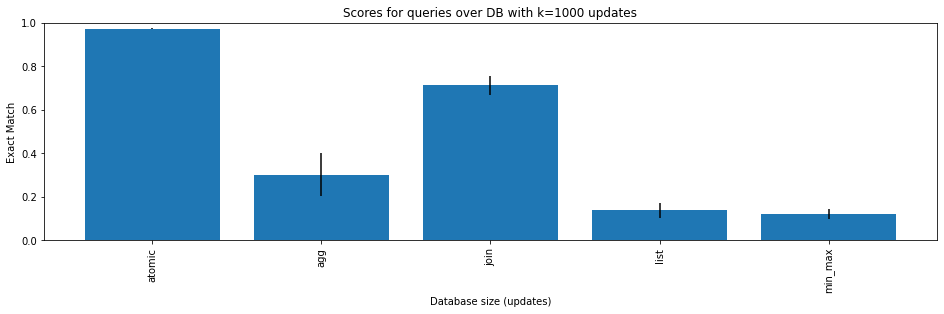

In [85]:
data_sizes = [50,100,500,1000,2000,5000,7000,1000]


a=[]
for size in data_sizes:
    plt.figure(figsize=(16,4))
    plt.title("Scores for queries over DB with k={} updates".format(size))
    plt.xlabel("Database size (updates)")
    plt.ylabel("Exact Match")
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    means = [breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in query_cols]
    std = [breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in query_cols]

    plt.bar([col.replace("query_","") for col in query_cols],means,yerr=std)



    plt.show()

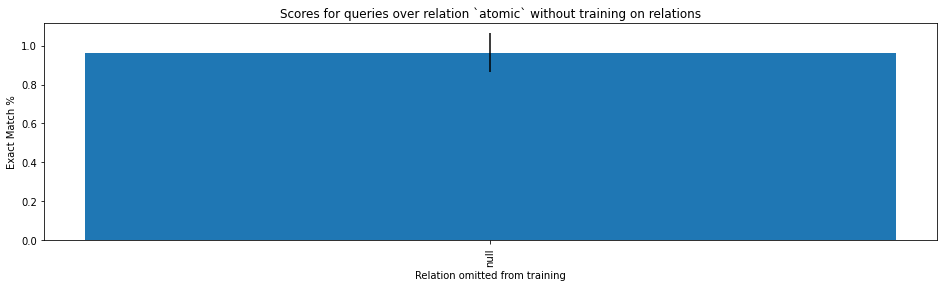

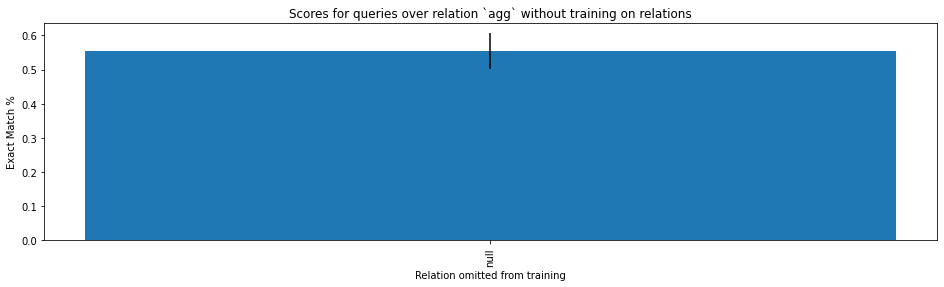

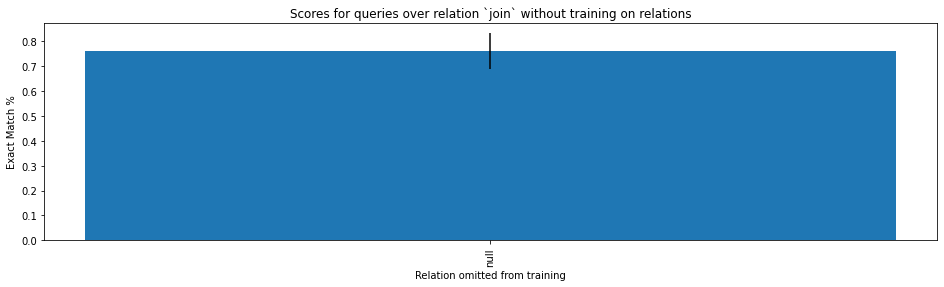

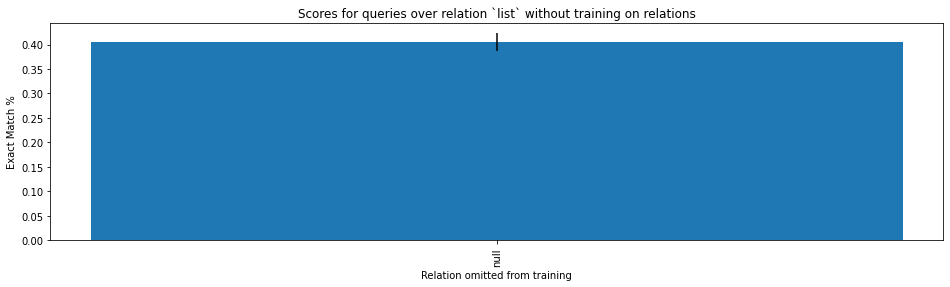

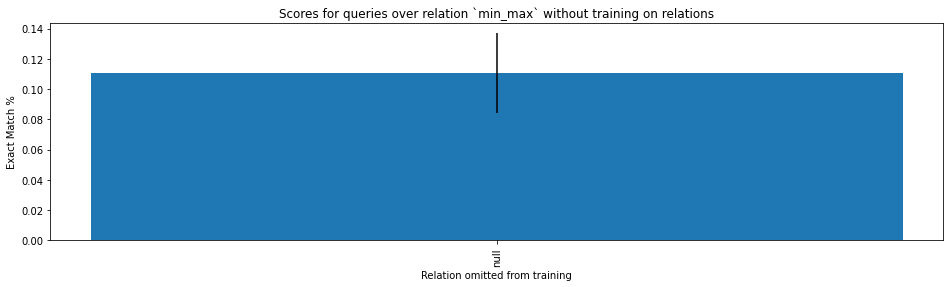

In [25]:
for col in breakdown_cols:
    means = breakdown[col]["mean"].T["t5-base"]["50"]
    std = breakdown[col]["std"].T["t5-base"]["50"]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=90)

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Relation omitted from training")
    plt.ylabel("Exact Match %")
    plt.bar([i.replace('.',' and ') for i in means.index], means, yerr=std)
    plt.show()